Building network
Connecting devices
Connecting network
Excitatory connections
Inhibitory connections
Simulating
Brunel network simulation (Python)
Number of neurons : 12500
Number of synapses: 15637600
       Exitatory  : 12512500
       Inhibitory : 3125000
Excitatory rate   : 31.86 Hz
Inhibitory rate   : 32.02 Hz
Building time     : 2.96 s
Simulation time   : 30.49 s


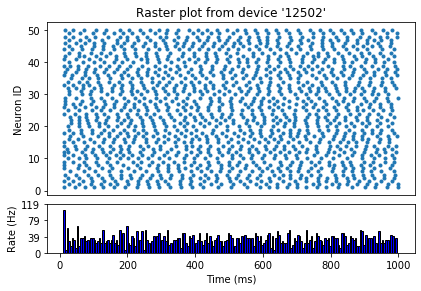

In [9]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import nest
import nest.raster_plot

import numpy as np

import time
from numpy import exp

nest.ResetKernel()

startbuild = time.time()

dt = 0.1  # the resolution in ms
simtime = 1000.0  # Simulation time in ms
delay = 1.5  # synaptic delay in ms

g = 5.0  # ratio inhibitory weight/excitatory weight
eta = 2.0  # external rate relative to threshold rate
epsilon = 0.1  # connection probability

order = 2500
NE = 4 * order  # number of excitatory neurons
NI = 1 * order  # number of inhibitory neurons
N_neurons = NE + NI  # number of neurons in total
N_rec = 50  # record from 50 neurons

CE = int(epsilon * NE)  # number of excitatory synapses per neuron
CI = int(epsilon * NI)  # number of inhibitory synapses per neuron
C_tot = int(CI + CE)  # total number of synapses per neuron

tauMem = 20.0  # time constant of membrane potential in ms
theta = 20.0  # membrane threshold potential in mV
neuron_params = {"C_m": 1.0,
                 "tau_m": tauMem,
                 "t_ref": 2.0,
                 "E_L": 0.0,
                 "V_reset": 0.0,
                 "V_m": 0.0,
                 "V_th": theta}
J = 0.1  # postsynaptic amplitude in mV
J_ex = J  # amplitude of excitatory postsynaptic potential
J_in = -g * J_ex  # amplitude of inhibitory postsynaptic potential

nu_th = theta / (J * CE * tauMem)
nu_ex = eta * nu_th
p_rate = 1000.0 * nu_ex * CE

nest.SetKernelStatus({"resolution": dt, "print_time": True,
                      "overwrite_files": True})

print("Building network")

nest.SetDefaults("iaf_psc_delta", neuron_params)
nest.SetDefaults("poisson_generator", {"rate": p_rate})

nodes_ex = nest.Create("iaf_psc_delta", NE)
nodes_in = nest.Create("iaf_psc_delta", NI)
noise = nest.Create("poisson_generator")
espikes = nest.Create("spike_detector")
ispikes = nest.Create("spike_detector")

nest.SetStatus(espikes, [{"label": "brunel-py-ex",
                          "withtime": True,
                          "withgid": True,
                          "to_file": True}])

nest.SetStatus(ispikes, [{"label": "brunel-py-in",
                          "withtime": True,
                          "withgid": True,
                          "to_file": True}])

print("Connecting devices")

nest.CopyModel("static_synapse", "excitatory",
               {"weight": J_ex, "delay": delay})
nest.CopyModel("static_synapse", "inhibitory",
               {"weight": J_in, "delay": delay})

nest.Connect(noise, nodes_ex, syn_spec="excitatory")
nest.Connect(noise, nodes_in, syn_spec="excitatory")

nest.Connect(nodes_ex[:N_rec], espikes, syn_spec="excitatory")
nest.Connect(nodes_in[:N_rec], ispikes, syn_spec="excitatory")

print("Connecting network")

print("Excitatory connections")

conn_params_ex = {'rule': 'fixed_indegree', 'indegree': CE}
nest.Connect(nodes_ex, nodes_ex + nodes_in, conn_params_ex, "excitatory")

print("Inhibitory connections")

conn_params_in = {'rule': 'fixed_indegree', 'indegree': CI}
nest.Connect(nodes_in, nodes_ex + nodes_in, conn_params_in, "inhibitory")

endbuild = time.time()

print("Simulating")

nest.Simulate(simtime)

endsimulate = time.time()

events_ex = nest.GetStatus(espikes, "n_events")[0]
events_in = nest.GetStatus(ispikes, "n_events")[0]

rate_ex = events_ex / simtime * 1000.0 / N_rec
rate_in = events_in / simtime * 1000.0 / N_rec

num_synapses = (nest.GetDefaults("excitatory")["num_connections"] +
                nest.GetDefaults("inhibitory")["num_connections"])

build_time = endbuild - startbuild
sim_time = endsimulate - endbuild

print("Brunel network simulation (Python)")
print("Number of neurons : {0}".format(N_neurons))
print("Number of synapses: {0}".format(num_synapses))
print("       Exitatory  : {0}".format(int(CE * N_neurons) + N_neurons))
print("       Inhibitory : {0}".format(int(CI * N_neurons)))
print("Excitatory rate   : %.2f Hz" % rate_ex)
print("Inhibitory rate   : %.2f Hz" % rate_in)
print("Building time     : %.2f s" % build_time)
print("Simulation time   : %.2f s" % sim_time)

nest.raster_plot.from_device(espikes, hist=True)